# Imports

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
          'figure.titlesize': 'x-large',
          'figure.dpi': 150,
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'savefig.bbox': 'tight'}

plt.rcParams.update(params)

# Processing

In [3]:
df= pd.read_csv('Model Performance.csv')
df.head()

,Model,Region,RMSE,MAPE
0,Dist Lambda,NO1,50.038285,20.99
1,Dist Lambda,NO3,1.097196,5.75
2,Dist Lambda,NO5,48.913816,21.15
3,Dist Lambda,SE1,13.878365,85.98
4,Dist Lambda,SE3,102.345606,127.70


In [7]:
rmse = df.pivot(index='Region',columns='Model', values='RMSE')
rmse['ratio_prob'] = (rmse['Dist Lambda'] - rmse['Historical average'])/rmse['Historical average']
rmse['ratio_lstm'] = (rmse['LSTM'] - rmse['Historical average'])/rmse['Historical average']
rmse['ratio_sarima'] = (rmse['SARIMA'] - rmse['Historical average'])/rmse['Historical average']
rmse.head(10)

Model,Dist Lambda,Historical average,LSTM,SARIMA,ratio_prob,ratio_lstm,ratio_sarima
Region,,,,,,,
DK1,176.052317,151.971754,163.903469,440.076518,0.158454,0.078513,1.895778
DK2,174.636174,150.881688,179.181357,465.170973,0.157438,0.187562,2.083018
NO1,50.038285,122.434504,29.523003,154.181899,-0.591306,-0.758867,0.259301
NO3,1.097196,19.714497,1.553508,26.071034,-0.944346,-0.921200,0.322430
NO5,48.913816,120.899558,33.864665,156.132551,-0.595418,-0.719894,0.291424
SE1,13.878365,26.334797,6.010776,57.410226,-0.473003,-0.771755,1.180014
SE3,102.345606,112.124797,109.845294,369.370573,-0.087217,-0.020330,2.294281
SE4,113.618899,118.277126,102.210768,911.975722,-0.039384,-0.135837,6.710500


In [25]:
plotting=rmse[['ratio_prob', 'ratio_lstm', 'ratio_sarima']]
plotting.columns=['Probabilistic LSTM', 'Point LSTM', 'SARIMA']
plotting= plotting.T
plotting.head()

Region,DK1,DK2,NO1,NO3,NO5,SE1,SE3,SE4
Probabilistic LSTM,0.158454,0.157438,-0.591306,-0.944346,-0.595418,-0.473003,-0.087217,-0.039384
Point LSTM,0.078513,0.187562,-0.758867,-0.921200,-0.719894,-0.771755,-0.020330,-0.135837
SARIMA,1.895778,2.083018,0.259301,0.322430,0.291424,1.180014,2.294281,6.710500


# Plotting

In [13]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    
    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


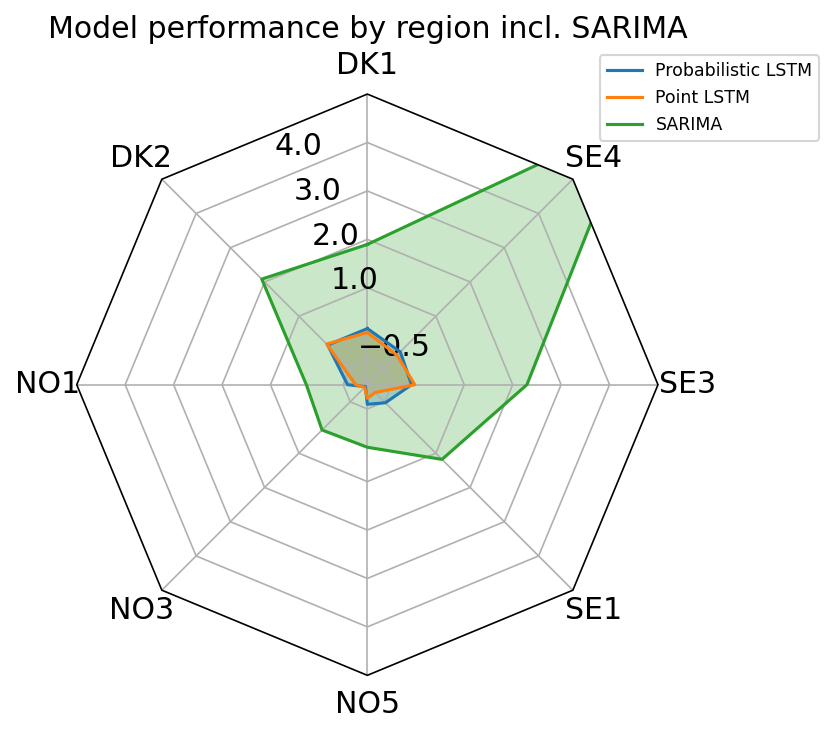

In [64]:
plt.rcParams.update(params)

data = [['DK1', 'DK2', 'NO1', 'NO3', 'NO5', 'SE1', 'SE3', 'SE4'],
        ('Model performance by region incl. SARIMA', [
                     plotting.loc['Probabilistic LSTM'].tolist(), 
                     plotting.loc['Point LSTM'].tolist(),
                     plotting.loc['SARIMA'].tolist()
                  ]
        )]

N = len(data[0])
theta = radar_factory(N, frame='polygon')                                     

spoke_labels = data.pop(0)
title, case_data = data[0]
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
ax.set_rgrids([ -.5, 1, 2, 3, 4])
ax.set_title(title,  position=(0.5, 1.1), ha='center')
#model_name = None # Set correct value (Folder)
for d in case_data:
    line = ax.plot(theta, d)
    ax.fill(theta, d, alpha=0.25)
ax.set_varlabels(spoke_labels)
labels = ('Probabilistic LSTM', 'Point LSTM', 'SARIMA')
# Ensure radar goes from 0 to 100.
ax.set_ylim(-1, 5)
ax.legend(labels, loc=(0.9, .92), fontsize='small')
# if model_name:
fig.savefig(f'Plots/{title}.jpg')
plt.show()

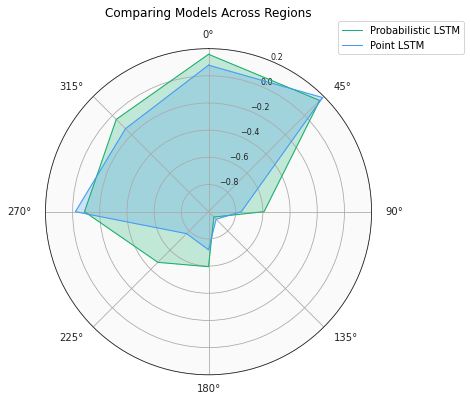

In [47]:
# Each attribute we'll plot in the radar chart.
labels = ['DK1', 'DK2', 'NO1', 'NO3', 'NO5', 'SE1', 'SE3', 'SE4']

# Number of variables we're plotting.
num_vars = len(labels)

# Split the circle into even parts and save the angles
# so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
angles += angles[:1]

# ax = plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Helper function to plot each car on the radar chart.
def add_to_radar(model, color):
  values = plotting.loc[model].tolist()
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=1, label=model)
  ax.fill(angles, values, color=color, alpha=0.25)

# Add each car to the chart.
add_to_radar('Probabilistic LSTM', '#1aaf6c')
add_to_radar('Point LSTM', '#429bf4')
#add_to_radar('SARIMA', '#d42cea')

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.
#ax.set_thetagrids(np.degrees(angles), labels)

# Go through labels and adjust alignment based on where
# it is in the circle.
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')

# Ensure radar goes from 0 to 100.
ax.set_ylim(-1, 0.2)
# You can also set gridlines manually like this:
# ax.set_rgrids([20, 40, 60, 80, 100])

# Set position of y-labels (0-100) to be in the middle
# of the first two axes.
ax.set_rlabel_position(180 / num_vars)

# Add some custom styling.
# Change the color of the tick labels.
ax.tick_params(colors='#222222')
# Make the y-axis (0-100) labels smaller.
ax.tick_params(axis='y', labelsize=8)
# Change the color of the circular gridlines.
ax.grid(color='#AAAAAA')
# Change the color of the outermost gridline (the spine).
ax.spines['polar'].set_color('#222222')
# Change the background color inside the circle itself.
ax.set_facecolor('#FAFAFA')

# Add title.
ax.set_title('Comparing Models Across Regions', y=1.08)

# Add a legend as well.
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))